In [ ]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
import os
from dateutil import parser
import datetime

Here we use numpy and pandas for handeling data,pyplot and seaborn for the visualization, yfinance for retrieving stock data,requests for retrieve news and nltk and transformers for sentiment analysis

In [ ]:
def get_stock_data(ticker, start_date, end_date):
    data = yf.Ticker(ticker)
    data = data.history(start=start_date, end=end_date)
    data.to_csv(f"{ticker}_stock_data.csv")

In [ ]:
ticker=input("Enter ticker: ")
start_date=input("Enter start date: ")
end_date=input("Enter end date: ")
get_stock_data(ticker,start_date,end_date)

Enter ticker: AAPL
Enter start date: 2024-01-25
Enter end date: 2025-02-25


**For the history function following args should be passed**

 period: data period to download (either use period parameter or use start and end) Valid periods are:
“1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”

interval: data interval (1m data is only for available for last 7 days, and data interval <1d for the last 60 days) Valid intervals are:
“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”

start: If not using period – in the format (yyyy-mm-dd) or datetime.

end: If not using period – in the format (yyyy-mm-dd) or datetime.

In [ ]:
# To get multiple tickers
def get_data(ticker,start_date,end_date):
    data=yf.download(ticker,start=start_date,end=end_date)
    data.to_csv(f"{ticker}_stock_data.csv")

In [ ]:
df=pd.read_csv("AAPL_stock_data.csv")
print(df.columns)
df


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-01-25 00:00:00-05:00,194.054921,195.098658,191.957513,193.011185,54822100,0.0,0.0
1,2024-01-26 00:00:00-05:00,193.110587,193.597653,190.794491,191.271622,44594000,0.0,0.0
2,2024-01-29 00:00:00-05:00,190.864082,191.052951,188.448592,190.585754,47145600,0.0,0.0
3,2024-01-30 00:00:00-05:00,189.800472,190.655340,186.351180,186.917770,55859400,0.0,0.0
4,2024-01-31 00:00:00-05:00,185.923728,185.983383,183.249795,183.299484,55467800,0.0,0.0
...,...,...,...,...,...,...,...,...
266,2025-02-18 00:00:00-05:00,244.149994,245.179993,241.839996,244.470001,48822500,0.0,0.0
267,2025-02-19 00:00:00-05:00,244.660004,246.009995,243.160004,244.869995,32204200,0.0,0.0
268,2025-02-20 00:00:00-05:00,244.940002,246.779999,244.289993,245.830002,32316900,0.0,0.0
269,2025-02-21 00:00:00-05:00,245.949997,248.690002,245.220001,245.550003,53197400,0.0,0.0


In [ ]:
# Define standard column names
COLUMN_MAPPING = {
    'Date': 'Date',
    'Trading Date': 'Date',
    'Close': 'Close',
    'Close Price': 'Close',
    'Closing Price': 'Close',
    'Close/Last': 'Close',
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low',
    'Volume': 'Volume',
    'Adj Close': 'Adj Close'
}

FINAL_COLUMNS = ['Date', 'Close']

def clean_csv(df):
    df.rename(columns=COLUMN_MAPPING, inplace=True)

    if 'Date' in df.columns:
        df['Date'] = df['Date'].apply(lambda x: parser.parse(str(x)).strftime('%Y-%m-%d'))

    if 'Close' in df.columns:
        if df['Close'].astype(str).str.contains(r'\$', regex=True).any():
            df['Close'] = df['Close'].astype(str).str.replace(r'[\$,]', '', regex=True)

        # Convert Close column to numeric values
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Keep only necessary columns if they exist
    df = df[[col for col in FINAL_COLUMNS if col in df.columns]]
    #Index with the date
    df.index=df.pop("Date")
    df = df.sort_values(by='Date', ascending=True)
    return df

In [ ]:
# Handle NA values
def handle_na(df):
  df.dropna(inplace=True)
  return df

In [ ]:
df=pd.read_csv("AAPL_stock_data.csv")
df=clean_csv(df)
df=handle_na(df)
df

,Close
Date,
2024-01-25,193.011185
2024-01-26,191.271622
2024-01-29,190.585754
2024-01-30,186.917770
2024-01-31,183.299484
...,...
2025-02-18,244.470001
2025-02-19,244.869995
2025-02-20,245.830002


Here the date is a String for our convinience we conert date to a datetime object.

And for the easiness we renamed the column **Close/Last** to **Close**.

In [ ]:
def get_graph(df):
  df['Close'].plot(kind='line', figsize=(8, 4), title='Volume')
  plt.gca().spines[['top', 'right']].set_visible(False)

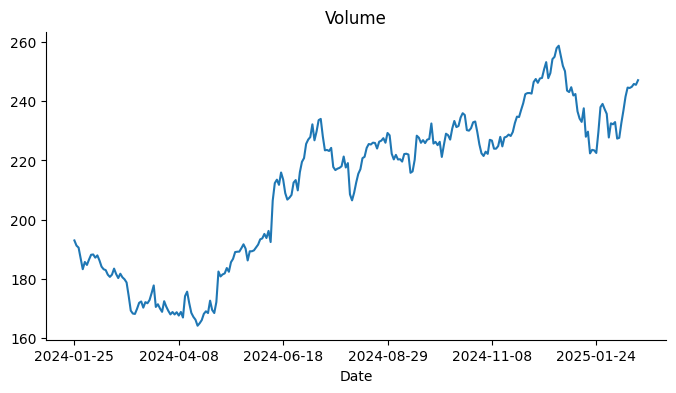

In [ ]:
get_graph(df)

In [ ]:
import pandas as pd
import numpy as np
import datetime
from dateutil import parser

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert index to datetime
    dataframe.index = pd.to_datetime(dataframe.index)

    first_date = parser.parse(first_date_str)
    last_date = parser.parse(last_date_str)

    target_date = first_date
    dates, X, Y = [], [], []

    while target_date <= last_date:
        try:
            # Select only the last (n+1) rows before target_date
            df_subset = dataframe.loc[:target_date].iloc[-(n+1):]

            if len(df_subset) != n+1:
                print(f'Error: Window of size {n} is too large for date {target_date}')
                break  # Stop instead of returning immediately

            values = df_subset['Close'].to_numpy()
            x, y = values[:-1], values[-1]

            dates.append(target_date)
            X.append(x)
            Y.append(y)

            # Find the next valid date in the dataframe
            next_dates = dataframe.index[dataframe.index > target_date]
            if not next_dates.empty:
                target_date = next_dates[0]
            else:
                break

        except Exception as e:
            print(f"Error processing date {target_date}: {e}")
            break

    # Convert results into a DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})

    X = np.array(X)
    for i in range(n):
        ret_df[f'Feature-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Running the function
windowed_df = df_to_windowed_df(df, '2024-06-01', '2025-02-21', n=3)
windowed_df

,Target Date,Feature-3,Feature-2,Feature-1,Target
0,2024-06-01,189.353592,189.652588,190.649246,191.606033
1,2024-06-03,189.652588,190.649246,191.606033,193.380066
2,2024-06-04,190.649246,191.606033,193.380066,193.699005
3,2024-06-05,191.606033,193.380066,193.699005,195.213898
4,2024-06-06,193.380066,193.699005,195.213898,193.828552
...,...,...,...,...,...
177,2025-02-14,232.619995,236.869995,241.529999,244.600006
178,2025-02-18,236.869995,241.529999,244.600006,244.470001
179,2025-02-19,241.529999,244.600006,244.470001,244.869995
180,2025-02-20,244.600006,244.470001,244.869995,245.830002


In [ ]:
def windowed_df_to_np(windowed_df):
  np_df=windowed_df.to_numpy()
  dates=np_df[:,0]
  features=np_df[:,1:-1]
  X=features.reshape(len(dates),features.shape[1],1)
  Y=np_df[:,-1]
  return dates,X.astype(np.int32),Y.astype(np.int32)

In [ ]:
dates,X,Y=windowed_df_to_np(windowed_df)

In [ ]:
def split_data(dates,X,Y):
  q_80=int(len(dates)*0.8)
  q_90=int(len(dates)*0.9)

  dates_train,X_train,Y_train=dates[:q_80],X[:q_80],Y[:q_80]
  dates_val,X_val,Y_val=dates[q_80:q_90],X[q_80:q_90],Y[q_80:q_90]
  dates_test,X_test,Y_test=dates[q_90:],X[q_90:],Y[q_90:]

  return dates_train,X_train,Y_train,dates_val,X_val,Y_val,dates_test,X_test,Y_test


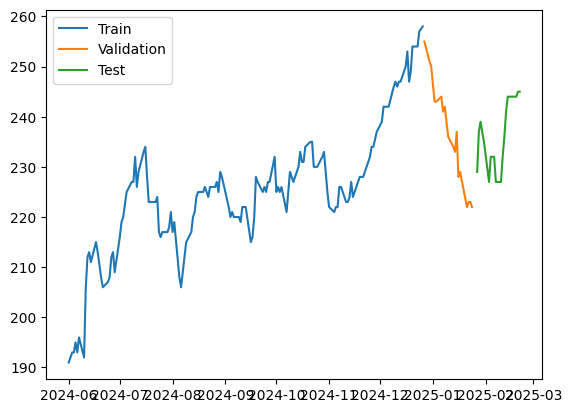

In [ ]:
dates_train,X_train,Y_train,dates_val,X_val,Y_val,dates_test,X_test,Y_test=split_data(dates,X,Y)

plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)
plt.legend(['Train','Validation','Test'])
plt.show()

In [ ]:
import neptune
run = neptune.init_run(
    project="madbe/CO-542-project",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YmU1N2M3OC01ODM4LTQ2MTItYTAyMS04OTZhOTQxNjM5ODIifQ==",
)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/madbe/CO-542-project/e/COP-2


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam

# Define LSTM Model
model = Sequential([
    Input(shape=(3, 1)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])

# Define a custom callback to log metrics to Neptune
class NeptuneCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        run["train/loss"].log(logs["loss"])
        run["train/mae"].log(logs["mae"])
        run["val/loss"].log(logs["val_loss"])
        run["val/mae"].log(logs["val_mae"])

# Train the model with Neptune logging
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=500, callbacks=[NeptuneCallback()])

# Stop the Neptune run
run.stop()


Epoch 1/500


Exception ignored in: <function _xla_gc_callback at 0x78a3a4ba82c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 95ms/step - loss: 50842.5859 - mae: 225.0973 - val_loss: 56004.6523 - val_mae: 236.4348
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 50982.5234 - mae: 225.4487 - val_loss: 55900.9453 - val_mae: 236.2154
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 50060.1523 - mae: 223.3623 - val_loss: 55835.8594 - val_mae: 236.0776
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 50071.2227 - mae: 223.3673 - val_loss: 55768.8672 - val_mae: 235.9356
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 50772.3203 - mae: 224.9959 - val_loss: 55701.4180 - val_mae: 235.7926
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 50156.2695 - mae: 223.6573 - val_loss: 55624.1797 - val_mae: 235.6288
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 50185.8398 - mae: 223.6401 - val_loss: 55533.4805 - val_mae: 235.4362
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 50009.5156 - mae: 223.2536 - val_loss: 55414.5977 - val_m

In [ ]:
# With avoiding overfitting
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

model=Sequential([Input((3,1)),
                  LSTM(64),
                  Dropout(0.2),
                  Dense(32,activation='relu'),
                  Dropout(0.5),
                  Dense(32,activation='relu'),
                  Dense(1)
                  ])

model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=500, callbacks=[early_stop])



Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - loss: 51166.1172 - mean_absolute_error: 225.8704 - val_loss: 56271.5078 - val_mean_absolute_error: 236.9983
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 51206.9609 - mean_absolute_error: 225.9654 - val_loss: 55980.9531 - val_mean_absolute_error: 236.3846
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 50976.8477 - mean_absolute_error: 225.3984 - val_loss: 55789.0391 - val_mean_absolute_error: 235.9784
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 50693.0469 - mean_absolute_error: 224.7939 - val_loss: 55645.9805 - val_mean_absolute_error: 235.6751
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 50201.4805 - mean_absolute_error: 223.6959 - val_loss: 55500.5039 - val_mean_absolute_error: 235.3662
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 50046.2266 - mean_absolute_error: 223.3151 - val_loss: 55322.3594 - val_mean_absolute_error: 234.9874
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


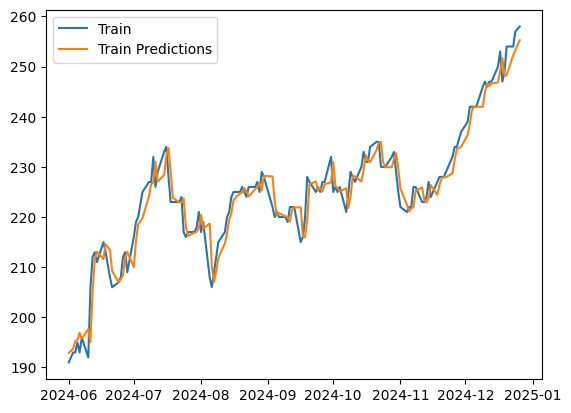

In [ ]:
train_predictions=model.predict(X_train).flatten()
plt.plot(dates_train,Y_train)
plt.plot(dates_train,train_predictions)
plt.legend(['Train','Train Predictions'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


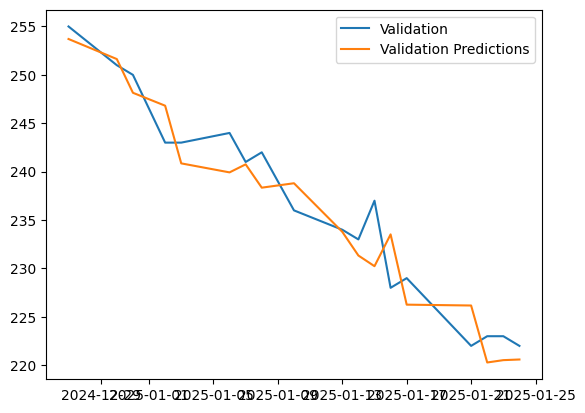

In [ ]:
val_predictions=model.predict(X_val).flatten()
plt.plot(dates_val,Y_val)
plt.plot(dates_val,val_predictions)
plt.legend(['Validation','Validation Predictions'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


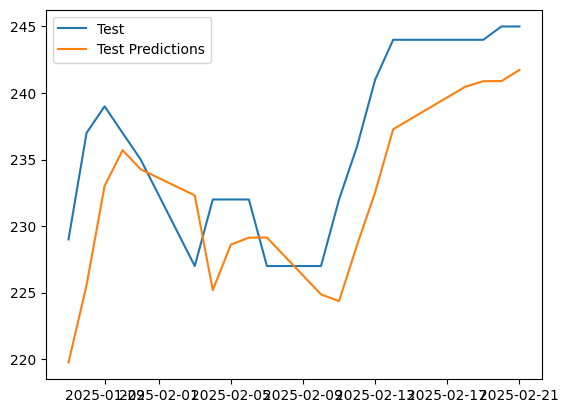

In [ ]:
test_predictions=model.predict(X_test).flatten()
plt.plot(dates_test,Y_test)
plt.plot(dates_test,test_predictions)
plt.legend(['Test','Test Predictions'])
plt.show()

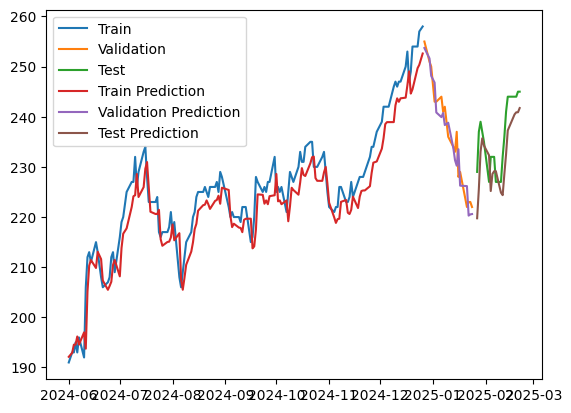

In [ ]:
plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)
plt.plot(dates_train,train_predictions)
plt.plot(dates_val,val_predictions)
plt.plot(dates_test,test_predictions)
plt.legend(['Train','Validation','Test','Train Prediction','Validation Prediction','Test Prediction'])
plt.show()

In [ ]:
accuracy,mae=model.evaluate(X_test,Y_test)
print(f"Accuracy: {accuracy:.2f}")
print(f"MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 33.5688 - mean_absolute_error: 5.0326
Accuracy: 33.57
MAE: 5.0326


In [ ]:
# Extract the last n=3 days from the dataset
last_n_days = df['Close'].values[-3:]  # Last 3 closing prices

# Reshape to match model input (samples, time steps, features)
input_data = last_n_days.reshape(1, 3, 1)

# Predict the next closing price
predicted_price = model.predict(input_data)[0][0]

print(f"Predicted stock price for the next day: {predicted_price}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted stock price for the next day: 243.69342041015625


In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = dates_test[-14:]
last_window  = X_test[-14]

for target_date in recursive_dates:
    print(last_window)
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    new_window = list(last_window[1:])
    new_window.append(next_prediction)
    new_window = np.array(new_window)
    last_window = new_window

[[239]
 [237]
 [235]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[237.        ]
 [235.        ]
 [233.95436096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[235.        ]
 [233.95436096]
 [232.74916077]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[233.95436096]
 [232.74916077]
 [231.54586792]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[232.74916077]
 [231.54586792]
 [230.34202576]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[231.54586792]
 [230.34202576]
 [229.13798523]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[230.34202576]
 [229.13798523]
 [227.9377594 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[229.13798523]
 [227.9377594 ]
 [226.74560547]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[227.9377594 ]
 [226.74560547]
 [225.5663147 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[226.74560547]
 [225.5663147 ]
 [224.40505981]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[225.5663147 ]
 [224.40505981]
 [223.26713562]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[224.40505981]
 [223.26713562]
 [222.1578064 ]]
1/1 ━━━━━━━━━━━━━━━━━

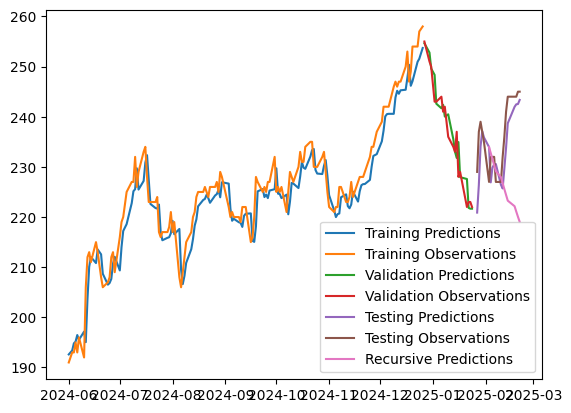

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

#**News Analysis**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [ ]:
from gnews import GNews

def get_news_api(stock_name):
    google_news = GNews(language='en', country='US', period='1d')
    news = google_news.get_news(stock_name)
    return [(item['title'], item['url']) for item in news]

articles = get_news_api("Apple")
print(articles)


[('Why a Chinese Gadget Company Can Make an Electric Car and Apple Can’t - The New York Times', 'https://news.google.com/rss/articles/CBMiiAFBVV95cUxNQ2dyTXY5QXFFX0s5aWF5cnpmSnlGWVRaUURJUEJLTXhCREJJQ0NUZlZZVnB4QjZ2WndzNXRaeGJBZXVPYmoyaW05TDhMQV9JQmY1WGk1OVprQWJNRm5QSUFKRmw1NGhCWk12b1pLZWxFWmhFYkRkWXVsTW1Bb3FRZ1MzRXBySE9D?oc=5&hl=en-US&gl=US&ceid=US:en'), ('Apple’s mid-tier 512GB 13-inch M4 iPad Pro is $200 off at Amazon today, more from $849 - 9to5Toys', 'https://news.google.com/rss/articles/CBMifkFVX3lxTFB1RkRUZkZEc3NVdlVrNHQyOUxIb0xnN1BBZldJMVl5TDNwbmFSSDRhOGhBOG9TU2ljOUw3YzFZbG1rdTZRS3g2V2xyZlN5MVU3Zk55YUdETktoZ3J0ZEw4a2hJbjRleDRhaEZhc3dfVVVXdS1lX0pRMTJMS191UdIBfkFVX3lxTFB1RkRUZkZEc3NVdlVrNHQyOUxIb0xnN1BBZldJMVl5TDNwbmFSSDRhOGhBOG9TU2ljOUw3YzFZbG1rdTZRS3g2V2xyZlN5MVU3Zk55YUdETktoZ3J0ZEw4a2hJbjRleDRhaEZhc3dfVVVXdS1lX0pRMTJMS191UQ?oc=5&hl=en-US&gl=US&ceid=US:en'), ('Apple iPhone Critical Alert Already Safe For All Users - Forbes', 'https://news.google.com/rss/articles/CBMixAFBVV95cUxQ

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english") and word not in string.punctuation]
    return " ".join(tokens)


# The articles variable is a list of tuples, where each tuple contains (title, url)
# We need to apply preprocess_text only to the title (first element of the tuple)
processed_news = [preprocess_text(article[0]) for article in articles]  # Changed to article[0]
print(processed_news)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['chinese gadget company make electric car apple ’ new york times', 'apple ’ mid-tier 512gb 13-inch m4 ipad pro 200 amazon today 849 9to5toys', 'apple iphone critical alert already safe users forbes', "'s going apple stock motley fool", 'would like see apple camera lens module iphone 9to5mac', 'apple shareholders reject anti-dei proposal explained technology magazine', "'s going apple stock nasdaq", "n't miss 30 apple pencil pro mashable", 'apple ’ next-gen siri might delayed 2027 macworld', 'apple robots coming rumor mill thinks coming appleinsider', "apple intelligence breakthrough features wo n't come 2027 think apple truly lost ai race bgr", 'apple iphone 16e spells stock nasdaq aapl seeking alpha', "apple 's 500b us jobs ‘ investment ’ old old computerworld", 'apple macbook air m4 announcement due day according industry insider techradar', 'official 5k apple studio display onboard 12mp center stage cam 1,299 300 9to5toys', '10 apple watch features use everyday could video 9to5mac'

In [ ]:
# Analyze sentiment of each news headline
def analyze_sentiment(news_list):
    sentiments = []
    for article in news_list:
        result =finbert(article)
        sentiment = result[0]["label"]  # Positive, Negative, or Neutral
        sentiments.append(sentiment)
    return sentiments

# Example: Get sentiment for the news
news_sentiments = analyze_sentiment(processed_news)
print(news_sentiments)


['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Neutral', 

In [ ]:
import yfinance as yf

def get_stock_performance(stock_symbol):
    stock = yf.Ticker(stock_symbol)
    hist = stock.history(period="5d")  # Get last 5 days of data

    if hist.empty:
        return None  # Stock symbol may be incorrect

    price_change = (hist["Close"].iloc[-1] - hist["Close"].iloc[-2]) / hist["Close"].iloc[-2] * 100
    return round(price_change, 2)


In [ ]:
def generate_smart_recommendation(sentiments, stock_symbol):
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")

    # Get stock price movement
    price_change = get_stock_performance(stock_symbol)

    if price_change is None:
        return "Stock symbol not found"

    print(f"{stock_symbol} Stock Performance: {price_change}%")

    # Decision Logic
    if price_change < -3:  # If stock dropped more than 3%
        if positive_count > negative_count and price_change > -1:
            return "BUY (but cautious) "
        return "SELL  (Stock dropping fast)"

    elif price_change > 2:  # If stock is already rising fast
        if positive_count > negative_count:
            return "BUY  (Momentum is strong)"
        return "NEUTRAL  (Stock rising, but sentiment is mixed)"

    else:  # If stock is stable
        if positive_count > negative_count:
            return "BUY "
        elif negative_count > positive_count:
            return "SELL "
        else:
            return "NEUTRAL "

recommendation = generate_smart_recommendation(news_sentiments, "AAPL")
print("Market Recommendation:", recommendation)



AAPL Stock Performance: 0.08%
Market Recommendation: BUY 


In [ ]:
model.save("model.h5")
